In [1]:
#importing datasets into colab
!gdown --id 1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
!gdown --id 1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_data.csv
100% 47.5M/47.5M [00:01<00:00, 42.0MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 40.9MB/s]


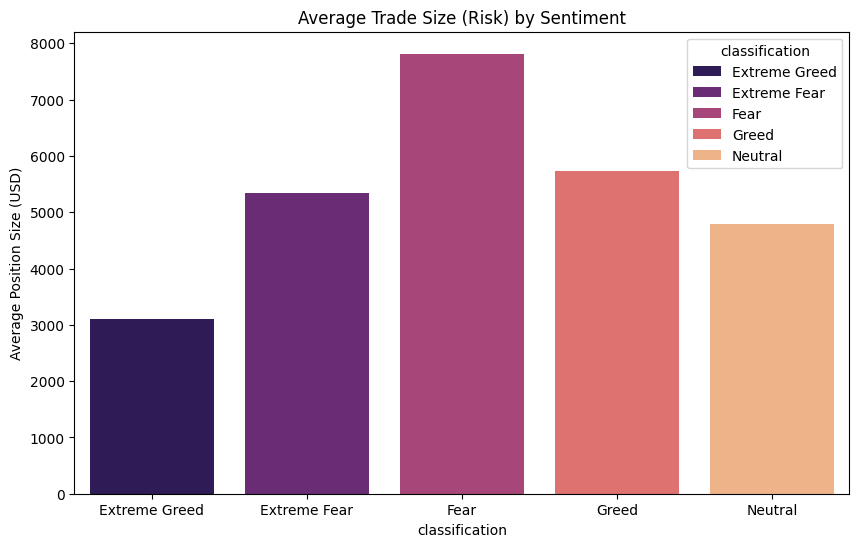

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

if not os.path.exists('outputs'):
    os.makedirs('outputs')


df_trades = pd.read_csv('historical_data.csv')
df_sentiment = pd.read_csv('fear_greed_index.csv')

# Clean Column Names
df_trades.columns = df_trades.columns.str.strip()
name_map = {'Closed PnL': 'closed PnL', 'closedPnL': 'closed PnL', 'Size': 'Size USD'}
df_trades.rename(columns=name_map, inplace=True)

# Convert Dates
df_trades['datetime'] = pd.to_datetime(df_trades['Timestamp IST'], dayfirst=True)
df_trades['date_join'] = df_trades['datetime'].dt.strftime('%Y-%m-%d')
df_sentiment['date_join'] = pd.to_datetime(df_sentiment['date']).dt.strftime('%Y-%m-%d')

# Clean Numerics (Remove commas)
for col in ['closed PnL', 'Size USD', 'Fee']:
    if col in df_trades.columns and df_trades[col].dtype == object:
        df_trades[col] = df_trades[col].str.replace(',', '').astype(float)

# Merge
df = df_trades.merge(df_sentiment, on='date_join', how='left')
df['Win'] = df['closed PnL'] > 0


# Chart 2: Risk Appetite (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='Size USD', data=df, estimator='mean', errorbar=None, palette="magma", hue='classification')
plt.title('Average Trade Size (Risk) by Sentiment')
plt.ylabel('Average Position Size (USD)')
plt.savefig('outputs/2_risk_size_barplot.png') # <--- SAVES IMAGE
plt.show()

/tmp/ipython-input-2348736156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='classification', y='Closed PnL', order=order, palette='coolwarm')


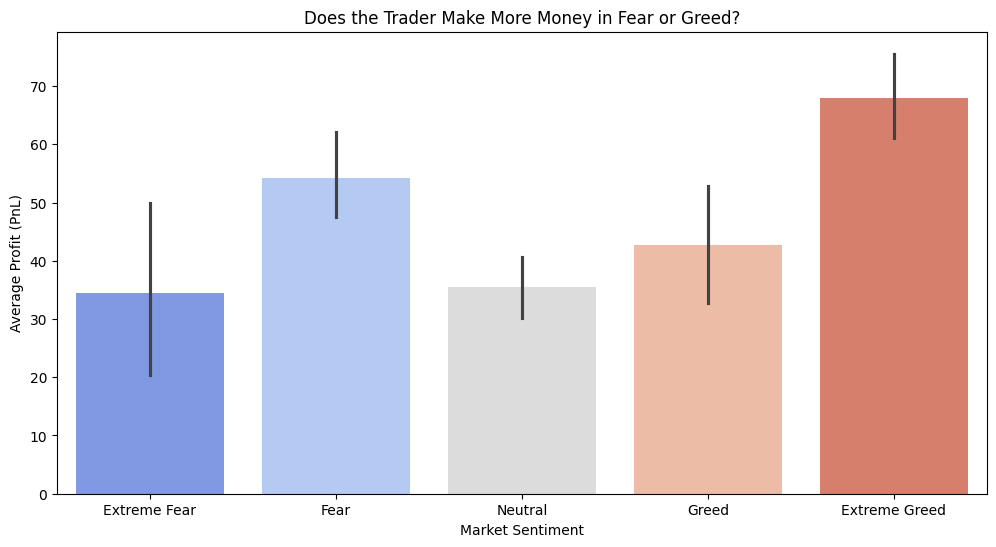

/tmp/ipython-input-2348736156.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='classification', order=order, palette='viridis')


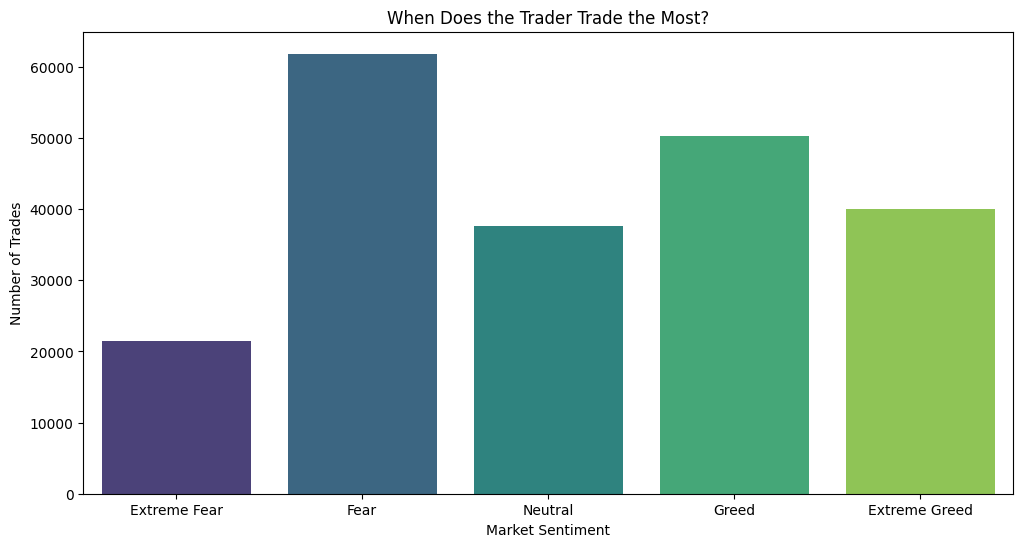

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

trades = pd.read_csv('historical_data.csv')
sent = pd.read_csv('fear_greed_index.csv')
trades['dt'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)
trades['join_date'] = trades['dt'].dt.strftime('%Y-%m-%d')

sent['join_date'] = pd.to_datetime(sent['date']).dt.strftime('%Y-%m-%d')
df = pd.merge(trades, sent[['join_date', 'value', 'classification']],
              on='join_date',
              how='left')
df['value'] = df['value'].fillna(50) # Neutral
df['classification'] = df['classification'].fillna('Neutral')
plt.figure(figsize=(12, 6))
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

sns.barplot(data=df, x='classification', y='Closed PnL', order=order, palette='coolwarm')
plt.title("Does the Trader Make More Money in Fear or Greed?")
plt.ylabel("Average Profit (PnL)")
plt.xlabel("Market Sentiment")
plt.show()


plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='classification', order=order, palette='viridis')
plt.title("When Does the Trader Trade the Most?")
plt.ylabel("Number of Trades")
plt.xlabel("Market Sentiment")
plt.show()

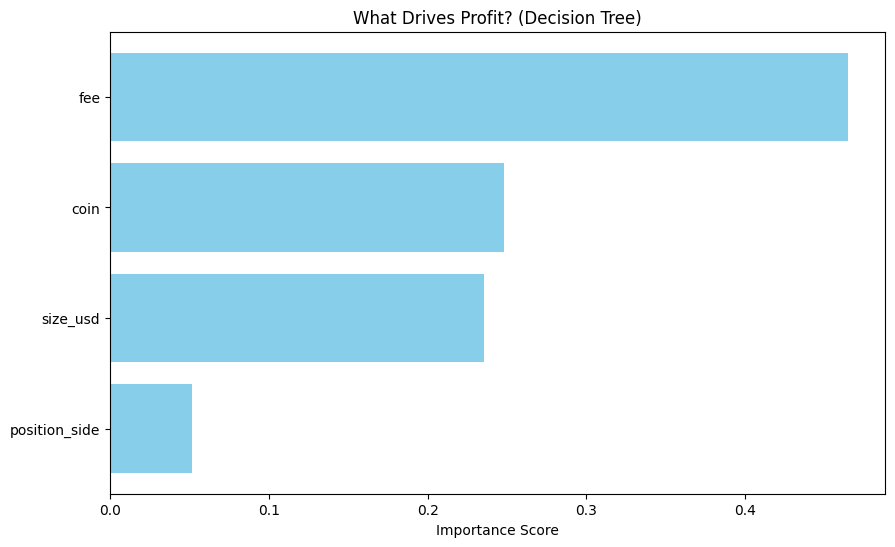

<Figure size 1000x800 with 0 Axes>

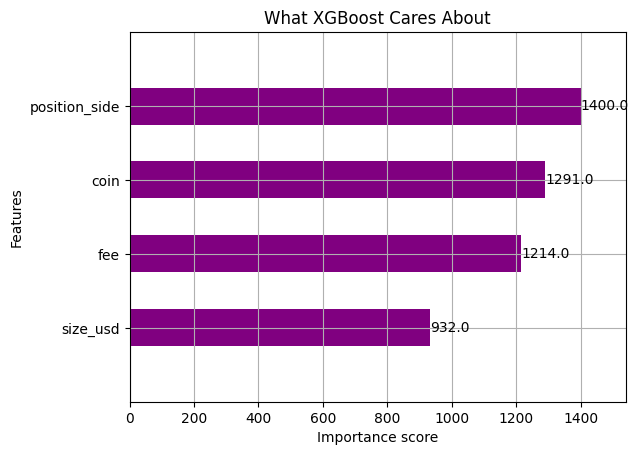

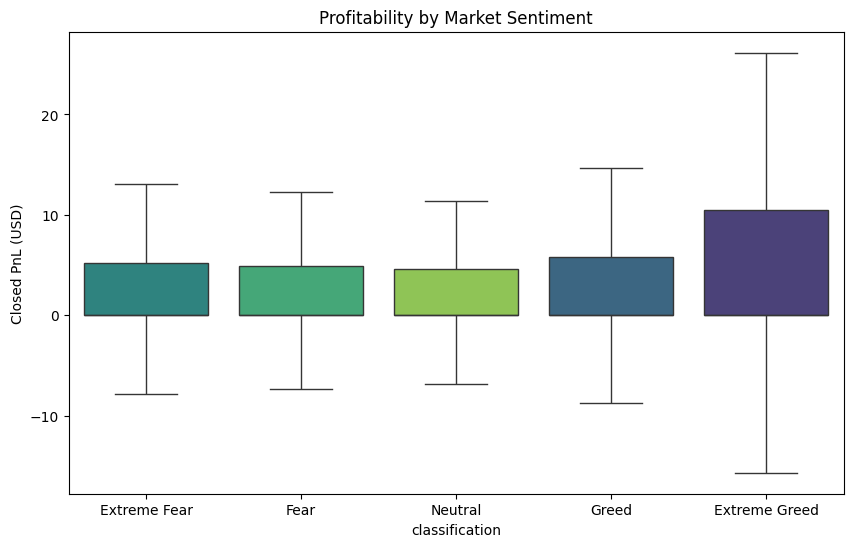

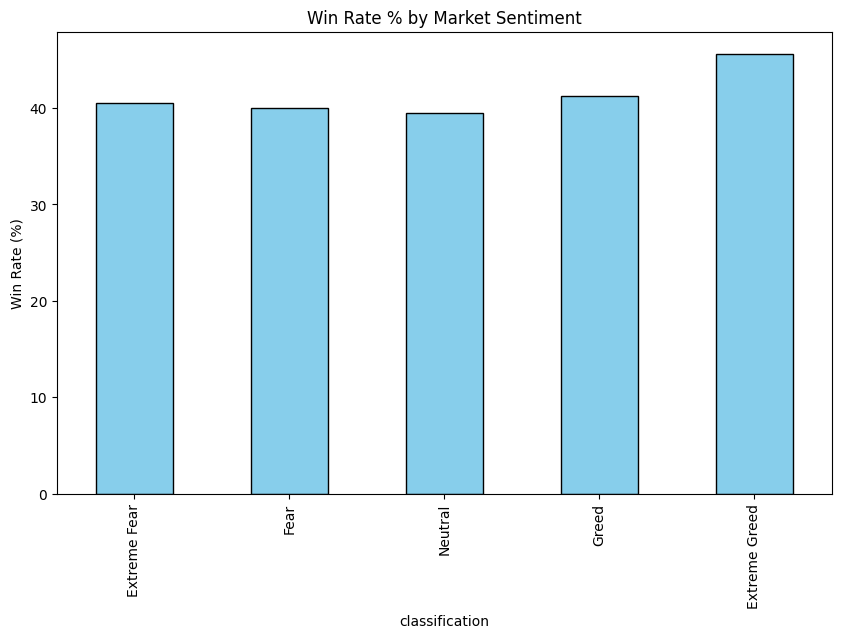

All tasks completed successfully.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance

# Create output folder if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')
df_trades = pd.read_csv('historical_data.csv')
df_sentiment = pd.read_csv('fear_greed_index.csv')
df_trades.columns = df_trades.columns.str.strip()

name_map = {
    'Closed PnL': 'closed_pnl',
    'closedPnL': 'closed_pnl', # Fallback
    'Size': 'size_usd',
    'Size USD': 'size_usd',
    'Coin': 'coin',
    'Start Position': 'position_side',
    'Fee': 'fee',
    'Timestamp IST': 'datetime'
}
df_trades.rename(columns=name_map, inplace=True)
df_trades['datetime'] = pd.to_datetime(df_trades['datetime'], dayfirst=True)
df_trades['date_join'] = df_trades['datetime'].dt.strftime('%Y-%m-d')

df_sentiment['date_join'] = pd.to_datetime(df_sentiment['date']).dt.strftime('%Y-%m-d')
cols_to_clean = ['closed_pnl', 'size_usd', 'fee']
for col in cols_to_clean:
    if col in df_trades.columns and df_trades[col].dtype == object:
        df_trades[col] = df_trades[col].str.replace(',', '').astype(float)

df = df_trades.merge(df_sentiment, on='date_join', how='left')

df['value'] = df['value'].fillna(50) # Neutral
df['classification'] = df['classification'].fillna('Neutral')
df['Win'] = df['closed_pnl'] > 0

feature_cols = ['coin', 'size_usd', 'position_side', 'fee']
target_col = 'closed_pnl'
missing_cols = [c for c in feature_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}. Check CSV headers.")

X = df[feature_cols].copy()
y = df[target_col]
le_coin = LabelEncoder()
X['coin'] = le_coin.fit_transform(X['coin'].astype(str))

le_pos = LabelEncoder()
X['position_side'] = le_pos.fit_transform(X['position_side'].astype(str))

X = X.fillna(0)
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeRegressor(max_depth=5, min_samples_leaf=20, random_state=42)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
df_importance = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
df_importance = df_importance.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Importance'], color='skyblue')
plt.title('What Drives Profit? (Decision Tree)')
plt.xlabel('Importance Score')
plt.show()

xgb_clf = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, n_jobs=-1, random_state=42)
xgb_clf.fit(X_train, y_train)

# Plot XGBoost Importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_clf, height=0.5, importance_type='weight', max_num_features=10, color='purple')
plt.title("What XGBoost Cares About")
plt.show()

sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# Chart 1: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='closed_pnl', data=df,
            showfliers=False, hue='classification', palette="viridis", order=sentiment_order)
plt.title('Profitability by Market Sentiment')
plt.ylabel('Closed PnL (USD)')
plt.savefig('outputs/1_profitability_boxplot.png')
plt.show()

# Chart 2: Win Rate
win_rates = df.groupby('classification')['Win'].mean() * 100
# Reindex to ensure logical order
win_rates = win_rates.reindex(sentiment_order)

plt.figure(figsize=(10, 6))
win_rates.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Win Rate % by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.savefig('outputs/2_win_rate.png')
plt.show()

print("All tasks completed successfully.")